In [2]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

from hydra import compose, initialize
from yolo import Config, PostProcess, create_converter, create_model, draw_bboxes
from yolo.utils.model_utils import get_device

from ifc_dl.conf.augmentations import get_transform_fn
from ifc_dl.data.mock_coco_dataset import MockCOCODataset
from ifc_dl.utils import plot_instance_segmentation_data
from ifc_dl.utils.io import get_config_for_notebook

project_root = Path().resolve().parent
sys.path.append(str(project_root))

print(project_root)

CONFIG_PATH = "../YOLO/yolo/config"
CONFIG_NAME = "config"
CLASS_NUM = 80

image_size = (640, 640)

with initialize(config_path=CONFIG_PATH, version_base=None, job_name="notebook_job"):
    cfg: Config = compose(config_name=CONFIG_NAME)

device, _ = get_device(cfg.device)
model = create_model(
    cfg.model,
    class_num=CLASS_NUM,
    weight_path="/Users/simone.bonato/Desktop/ecolution/IFC_DL/submodules/YOLO/weights/v9-c.pt",
)
model = model.to(device)

converter = create_converter(
    cfg.model.name, model, cfg.model.anchor, image_size, device
)
post_proccess = PostProcess(converter, cfg.task.nms)

In [3]:
cfg.model

{'name': 'v9-c', 'anchor': {'reg_max': 16, 'strides': [8, 16, 32]}, 'model': {'backbone': [{'Conv': {'args': {'out_channels': 64, 'kernel_size': 3, 'stride': 2, 'in_channels': 3}, 'source': 0}}, {'Conv': {'args': {'out_channels': 128, 'kernel_size': 3, 'stride': 2, 'in_channels': 64}}}, {'RepNCSPELAN': {'args': {'out_channels': 256, 'part_channels': 128, 'in_channels': 128}}}, {'ADown': {'args': {'out_channels': 256, 'in_channels': 256}}}, {'RepNCSPELAN': {'args': {'out_channels': 512, 'part_channels': 256, 'in_channels': 256}, 'tags': 'B3'}}, {'ADown': {'args': {'out_channels': 512, 'in_channels': 512}}}, {'RepNCSPELAN': {'args': {'out_channels': 512, 'part_channels': 512, 'in_channels': 512}, 'tags': 'B4'}}, {'ADown': {'args': {'out_channels': 512, 'in_channels': 512}}}, {'RepNCSPELAN': {'args': {'out_channels': 512, 'part_channels': 512, 'in_channels': 512}, 'tags': 'B5'}}], 'neck': [{'SPPELAN': {'args': {'out_channels': 512, 'in_channels': 512}, 'tags': 'N3'}}, {'UpSample': {'args'

In [4]:
my_config = get_config_for_notebook(
    "/Users/simone.bonato/Desktop/ecolution/IFC_DL/src/ifc_dl/conf"
)

augs = {
    "resize": {
        "params": {"height": image_size[0], "width": image_size[1], "interpolation": 3},
        "all_datasets": True,
    },
    "horizontal_flip": {"params": {"p": 0.5}},
}

transforms, val_transform = get_transform_fn(augs)

/Users/simone.bonato/anaconda3/envs/eco_yolo/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'main': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Loading the reduced COCO dataset...


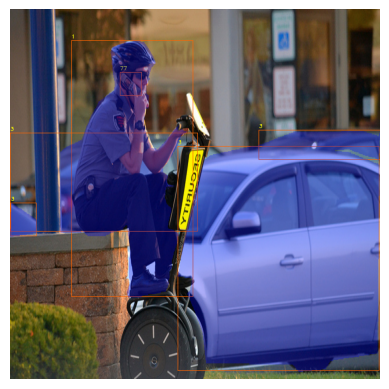

In [5]:
dataset = MockCOCODataset(partition="train", transforms=transforms)

x, y = dataset[1]

plot_instance_segmentation_data(x, y)

In [6]:
model_output = model(x[None])

model_output.keys()

dict_keys(['Main', 'AUX'])

### Notes on the shapes of the output

There are 3 tuples, one for each resolution (60x80, 30x40, 15, 20).
Within each tuple we have predictions for: class, objects and bounding boxes.

Takin the first tuple for example:

**Class predictions**:
- 80 is the number of object classes
- 60x80 is the feature map size 

**Object predictions**:
- 16 is the number of anchor boxes per cell
- 4 channels for bounding box parameters (x, y, width, height)
- 60x80 is the feature map size 

**Bounding box predictions**:
- 4 channels for bounding boxes
- 60x80 is the feature map size 

In [7]:
print("Main output shapes:")
for o in model_output["Main"]:
    for el in o:
        print(el.shape)
    print()


print("\nAUX output shapes:")
for o in model_output["AUX"]:
    for el in o:
        print(el.shape)
    print()

Main output shapes:
torch.Size([1, 80, 80, 80])
torch.Size([1, 16, 4, 80, 80])
torch.Size([1, 4, 80, 80])

torch.Size([1, 80, 40, 40])
torch.Size([1, 16, 4, 40, 40])
torch.Size([1, 4, 40, 40])

torch.Size([1, 80, 20, 20])
torch.Size([1, 16, 4, 20, 20])
torch.Size([1, 4, 20, 20])


AUX output shapes:
torch.Size([1, 80, 80, 80])
torch.Size([1, 16, 4, 80, 80])
torch.Size([1, 4, 80, 80])

torch.Size([1, 80, 40, 40])
torch.Size([1, 16, 4, 40, 40])
torch.Size([1, 4, 40, 40])

torch.Size([1, 80, 20, 20])
torch.Size([1, 16, 4, 20, 20])
torch.Size([1, 4, 20, 20])



In [8]:
post_processed = post_proccess(model_output)

for pred in post_processed:
    print(pred.shape)

torch.Size([1, 6])


In [38]:
post_processed[0].shape

torch.Size([1, 6])

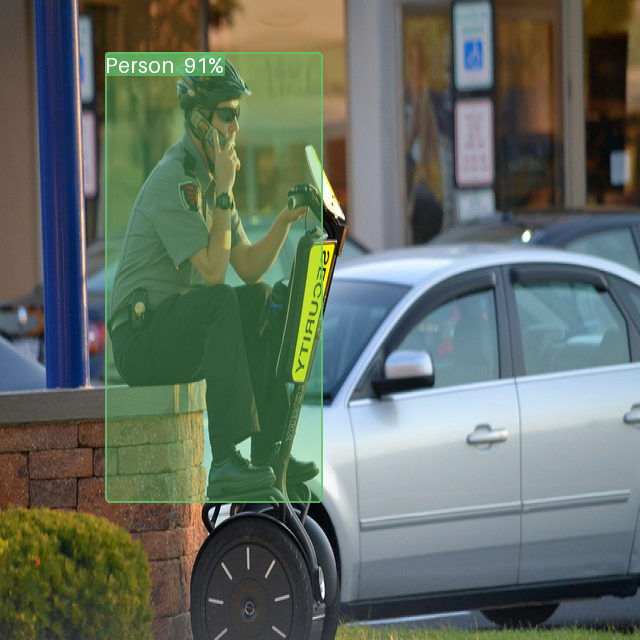

In [9]:
draw_bboxes(x, post_processed, idx2label=cfg.dataset.class_list)

### Notes on the loss function, the **DUAL LOSS**

It is made of the following losses:
- BCELoss (Binary Cross-Entropy Loss)
- DFLoss (Distribution Focal Loss)
- BoxLoss

#### How should the loss inputs look like?

- targets: The ground truth class and bounding box information as tensor of size [batch x targets x 5]

--> to have that shape, it means that all the images should have the same number of boxes... so there should be a label for the NO OBJECT class?

In [10]:
from yolo.tools.loss_functions import create_loss_function

loss = create_loss_function(cfg, converter)

loss

[03/26/25 17:08:35] INFO     ✅ Success load loss function                                    ]8;id=821872;file:///Users/simone.bonato/Desktop/ecolution/IFC_DL/submodules/YOLO/yolo/tools/loss_functions.py\loss_functions.py]8;;\:]8;id=870163;file:///Users/simone.bonato/Desktop/ecolution/IFC_DL/submodules/YOLO/yolo/tools/loss_functions.py#141\141]8;;\

In [ ]:
import torch





tensor([[  0.0000, 190.0400, 109.6216, 227.0100, 149.1171],
        [  0.0000, 290.7900, 237.0595, 639.0000, 625.3838],
        [  0.0000, 430.4700, 209.9748, 640.0000, 260.3099],
        [  0.0000, 106.2000,  54.6450, 316.7300, 497.6144],
        [  0.0000,   1.2500, 335.0198,  45.6000, 392.7640],
        [  0.0000,   0.9800, 214.0396, 324.2800, 384.9946]],
       dtype=torch.float64)

In [35]:
pred_scale_idx = 0

class_vec = torch.zeros(6, 1)
batch_size = model_output["Main"][pred_scale_idx][0].shape[0]
yolo_style_loss = torch.cat([class_vec, y["boxes"]], dim=1)[None].repeat(
    batch_size, 1, 1
)

loss_val = loss(
    model_output["AUX"][pred_scale_idx],
    model_output["Main"][pred_scale_idx],
    targets=yolo_style_loss,
)

RuntimeError: The size of tensor a (6) must match the size of tensor b (80) at non-singleton dimension 2

In [32]:
yolo_style_loss.shape

torch.Size([1, 80, 480, 400])

In [ ]:
cfg.task.validation

{'task': 'validation', 'data': {'batch_size': 32, 'image_size': '${image_size}', 'cpu_num': '${cpu_num}', 'shuffle': False, 'pin_memory': True, 'data_augment': {}, 'dynamic_shape': False}, 'nms': {'min_confidence': 0.0001, 'min_iou': 0.7, 'max_bbox': 1000}}